# Imports

In [158]:
import pandas as pd
import numpy as np

# Preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import nltk

# Preprocess features
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

# Preprocess targets
from sklearn.preprocessing import MinMaxScaler

#LSTM for regression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Evaluation

# Visulization
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leamayer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading

In [159]:
# Image Data
df = pd.read_csv("../Data/dataset_w_jpg.csv")
df = df.dropna()

df = df [["channel_title","tags","description","views"]]

df["views"] = df["views"].astype(int)

df

,channel_title,tags,description,views
0,EminemVEVO,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",Eminem's new track Walk on Water ft. Beyoncé i...,17158579
1,iDubbbzTV,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",STill got a lot of packages. Probably will las...,1014651
3,nigahiga,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",I know it's been a while since we did this sho...,2095828
4,Ed Sheeran,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,33523622
5,DramaAlert,"#DramaAlert|""Drama""|""Alert""|""DramaAlert""|""keem...",► Follow for News! - https://twitter.com/KEEMS...,1309699
...,...,...,...,...
41207,Россия 24,"поединок|""михеев""|""полный контакт""|""вечер с вл...",Вечер с Владимиром Соловьевым от 13.06.2018\rП...,201847
41208,Annoying Orange,"annoying orange|""funny""|""fruit""|""talking""|""ani...",🚨 NEW MERCH! http://amzn.to/annoyingorange 🚨➤ ...,80685
41210,Kingdom Hearts,"Kingdom Hearts|""KH3""|""Kingdom Hearts 3""|""Froze...",Find out more about Kingdom Hearts 3: https://...,773347
41211,The Young Turks,"180612__TB02SorryExcuse|""News""|""Politics""|""The...",Peter Navarro isn’t talking so tough now. Ana ...,115225


In [160]:
# Loas features and targets

feature_df = df [["channel_title","tags","description"]]  # Text data as numpy list
targets = df["views"].to_numpy()  # Target data as numpy list

## Preprocessing

### Normalize Targets

In [161]:
# Normalizing the target values with the min-max normalization

scaler = MinMaxScaler()
normalized_targets = scaler.fit_transform(targets.reshape(-1, 1)).flatten()

print(f">>> Range from original targets ({targets.min()};{targets.max()}) has been normalized ({normalized_targets.min()};{normalized_targets.max()})")

>>> Range from original targets (1000;137843120) has been normalized (0.0;1.0)


### Apply Stemmer and Remove Stopwords from Text Features

In [162]:
# Add content speficic stopwords by select the top N words with the highest TF-IDF scores as potential stopwords

def get_content_stopwords(texts):
    
    vectorizer = TfidfVectorizer() # TfidfVectorizer object from sklearn

    tfidf_matrix = vectorizer.fit_transform(texts) 

    feature_names = vectorizer.get_feature_names_out()

    avg_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0] # Get average TF-IDF score for each word

    word_scores = list(zip(feature_names, avg_tfidf_scores))

    word_scores.sort(key=lambda x: x[1], reverse=True) # Sort the word_scores in descending order

    N = 250 # Number of stopwords to select
    stopwords_content = [word for word, score in word_scores[:N]] # Potential stopwords

    print(f">>> {len(stopwords_content)} content specific stopwords are idintified")

    return stopwords_content

In [163]:
# Define stemmer and stopwords

def get_stopwords(texts):

    # Stopwords
    stop_words_nlkt = set(stopwords.words('english'))

    # add contect speficic stopwords 
    original_stopword_len = len(stop_words_nlkt)

    stop_words = stop_words_nlkt.copy()

    stop_words |= set(get_content_stopwords(texts)) # Add the additional wikipedia specific stopwords

    merged_stopword_len = len(stop_words)

    print(f">>> {merged_stopword_len-original_stopword_len} additional stopwords have been added to the nlkt stopwords list")

    return stop_words

In [164]:
# Get Stemmer
stemmer = SnowballStemmer('english')
feature_df_preprocessed = pd.DataFrame()


for feature in feature_df:

    print(f"\n--- Preprocessing {feature} feature ---\n")

    texts = df[feature].to_numpy()

    # Remove numbers and singel characters

    texts_preprocessed = [' '.join([word for word in text.split() if not word.isnumeric()]) for text in texts] # Remove numbers
    texts_preprocessed = [' '.join([word for word in text.split() if not len(word) > 1]) for text in texts] # Remove words with one character

    print(">>> Numbers and words with only one character are removed")

    # Get Stopwords
    stop_words = get_stopwords(texts)

    # Remove stop words from the text data and apply stemmer

    texts_preprocessed = [' '.join([stemmer.stem(word) for word in text.split() if word.lower() not in stop_words]) for text in texts]

    feature_df_preprocessed[feature] = texts_preprocessed

    print(">>> The Stemmer and the Stopword Removal are applied f.e.:\n")

    print (texts[5]) # show example
    print (texts_preprocessed[5])


--- Preprocessing channel_title feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are idintified
>>> 243 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

VanossGaming
vanossgam

--- Preprocessing tags feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are idintified
>>> 224 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

Funny Moments|"Montage video games"|"gaming"|"Vanoss"|"VanossGaming"|"Gameplay"|"Secret"|"Puncake"|"Parody"|"Comedy"|"Remix"|"Epic"|"Trolling"|"Xbox One"|"MultiplayerPS4"|"Funtage"|"superhero school"|"vanoss superhero school"|"superhero"|"scool"|"school"|"super hero"|"vanoss gaming school"|"doc"|"documentary"
moments|"montag games"|"gaming"|"vanoss"|"vanossgaming"|"gameplay"|"secret"|"puncake"|"parody"|"comedy"

### Tokenize and Split the Text Data

In [183]:
# Tokenize the text data
def tokenize (texts):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    # Vocabulary size
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences to a fixed length
    max_sequence_length = 100
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

    return padded_sequences, vocab_size

In [184]:
# Split the data into training and validation sets
def train_val_test_split(padded_sequences):
    
    train_texts, val_texts = train_test_split( padded_sequences, test_size=0.2, random_state=42) # train-validation split with validation size of 20%
    train_texts, test_texts = train_test_split( train_texts, test_size=0.125, random_state=42) # train-test split with test size of 10%

    print(f">>> Text shape train: {train_texts.shape} val: {val_texts.shape} test: {test_texts.shape}")

    return train_texts, val_texts, test_texts

In [185]:

# Split target data

print(f"\n--- Splitting Target Data ---\n")

train_targets, val_targets = train_test_split( normalized_targets, test_size=0.2, random_state=42) # train-validation split with validation size of 20%
train_targets, test_targets = train_test_split( train_targets, test_size=0.125, random_state=42) # train-test split with test size of 10%
print(f">>> Target shape train: {train_targets.shape} val: {val_targets.shape} test: {test_targets.shape}")


# Split feature data featurewise

split_names = ["train_texts", "val_texts", "test_texts"]
vocab_list = []

for feature in feature_df_preprocessed:
    
    print(f"\n--- Tokenizing and Splitting {feature} feature ---\n")

    texts = df[feature].to_numpy()

    return_values = tokenize(texts)

    padded_sequences = return_values[0]

    vocab_list.append(return_values[1])

    feature_df_preprocessed[feature] = padded_sequences

    split_list = train_val_test_split(padded_sequences)

    iterator = 0

    print(f">>> The Feature Splits are saved under the following names:")

    for split in split_list:
        variable_name = split_names[iterator]+"_"+feature
        print(variable_name)
        exec(variable_name + " = split")
        iterator+=1


--- Splitting Target Data ---

>>> Target shape train: (22410,) val: (6404,) test: (3202,)

--- Tokenizing and Splitting channel_title feature ---

>>> Text shape train: (22410, 100) val: (6404, 100) test: (3202, 100)
>>> The Feature Splits are saved under the following names:
train_texts_channel_title
val_texts_channel_title
test_texts_channel_title

--- Tokenizing and Splitting tags feature ---

>>> Text shape train: (22410, 100) val: (6404, 100) test: (3202, 100)
>>> The Feature Splits are saved under the following names:
train_texts_tags
val_texts_tags
test_texts_tags

--- Tokenizing and Splitting description feature ---

>>> Text shape train: (22410, 100) val: (6404, 100) test: (3202, 100)
>>> The Feature Splits are saved under the following names:
train_texts_description
val_texts_description
test_texts_description


# Model Training

In [196]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import concatenate

# Define the LSTM model with three text inputs
input1 = Input(shape=(max_sequence_length,))
input2 = Input(shape=(max_sequence_length,))
input3 = Input(shape=(max_sequence_length,))
embedding = Embedding(sum(vocab_list), 100)
lstm = LSTM(64)
dense = Dense(1, activation='linear')

embedded1 = embedding(input1)
embedded2 = embedding(input2)
embedded3 = embedding(input3)
lstm1 = lstm(embedded1)
lstm2 = lstm(embedded2)
lstm3 = lstm(embedded3)
concatenated = concatenate([lstm1, lstm2, lstm3])
output = dense(concatenated)

model = Model(inputs=[input1, input2, input3], outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 100, 100)     22379500    ['input_34[0][0]',               
                                                                  'input_35[0][0]',         

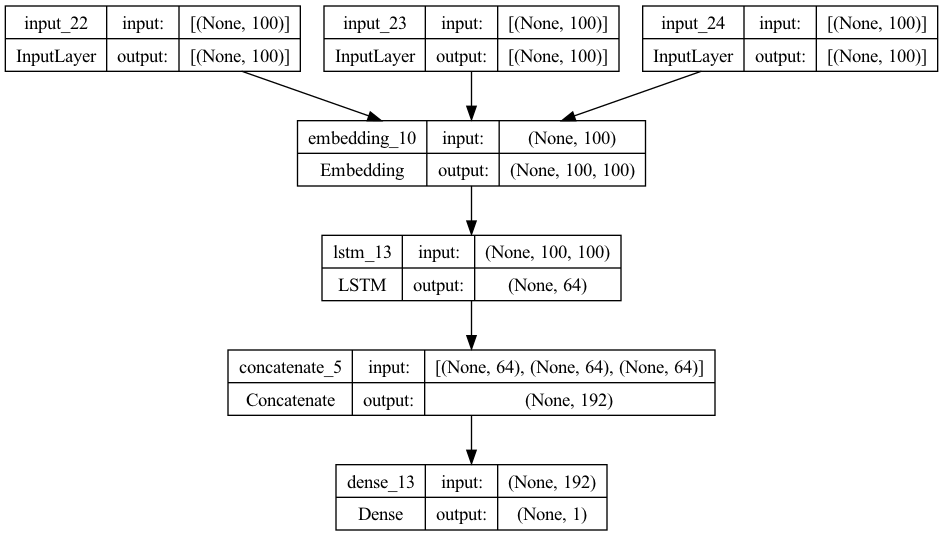

In [192]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

In [197]:
# Train the model
batch_size = 32
epochs = 10
history_three_features = model.fit([train_texts_channel_title, train_texts_tags, train_texts_description], train_targets, batch_size=batch_size, epochs=epochs, validation_data=([val_texts_channel_title, val_texts_tags, val_texts_description], val_targets))

'''# Make predictions
predictions = model.predict([test_texts_channel_title,test_texts_tags, test_texts_description])

# Convert normalized predictions back to original scale
original_predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Print the predictions
for i, prediction in enumerate(original_predictions):
    print(f"Sample {i+1}: Predicted Views = {prediction}")'''

    # https://stackoverflow.com/questions/65514944/tensorflow-embeddings-invalidargumenterror-indices18-16-11905-is-not-in-0

Epoch 1/10
602/701 [========================>.....] - ETA: 13s - loss: 5.8102e-04

KeyboardInterrupt: 

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_length))
model.add(LSTM(64))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Train the model
batch_size = 32
epochs = 10
history = model.fit(train_texts, train_targets, batch_size=batch_size, epochs=epochs, validation_data=(val_texts, val_targets))

Epoch 1/10
701/701 [==============================] - 42s 58ms/step - loss: 5.7358e-04 - val_loss: 6.2133e-04
Epoch 2/10
701/701 [==============================] - 37s 52ms/step - loss: 4.2834e-04 - val_loss: 5.0082e-04
Epoch 3/10
701/701 [==============================] - 38s 55ms/step - loss: 3.2502e-04 - val_loss: 3.4616e-04
Epoch 4/10
701/701 [==============================] - 40s 57ms/step - loss: 2.4866e-04 - val_loss: 2.8923e-04
Epoch 5/10
701/701 [==============================] - 41s 58ms/step - loss: 2.1050e-04 - val_loss: 2.8746e-04
Epoch 6/10
701/701 [==============================] - 40s 58ms/step - loss: 2.0737e-04 - val_loss: 3.0628e-04
Epoch 7/10
701/701 [==============================] - 40s 58ms/step - loss: 2.1138e-04 - val_loss: 2.8668e-04
Epoch 8/10
701/701 [==============================] - 40s 58ms/step - loss: 1.8486e-04 - val_loss: 2.5614e-04
Epoch 9/10
701/701 [==============================] - 37s 52ms/step - loss: 1.8657e-04 - val_loss: 3.1524e-04
Epoch 10/1

# Model Evaluation

## Evaluatie Loss

In [ ]:
# Evaluate the model

test_loss = model.evaluate(test_texts, test_targets)

test_loss 

101/101 [==============================] - 1s 12ms/step - loss: 2.2289e-04


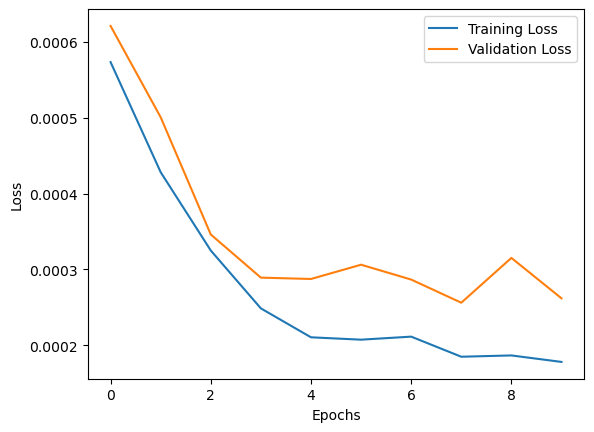

In [ ]:
# Plot training and validation loss

# Plot the loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Prediction

In [ ]:
# Make predictions
pred = model.predict(test_texts)

# Convert normalized predictions back to original scale
original_pred = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
original_targets = scaler.inverse_transform(test_targets.reshape(-1, 1)).flatten()

# Evaluation metrics
mse = mean_squared_error(original_targets, original_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

101/101 [==============================] - 1s 12ms/step
Mean Squared Error (MSE): 4234992105661.891
Root Mean Squared Error (RMSE): 2057909.6446787675


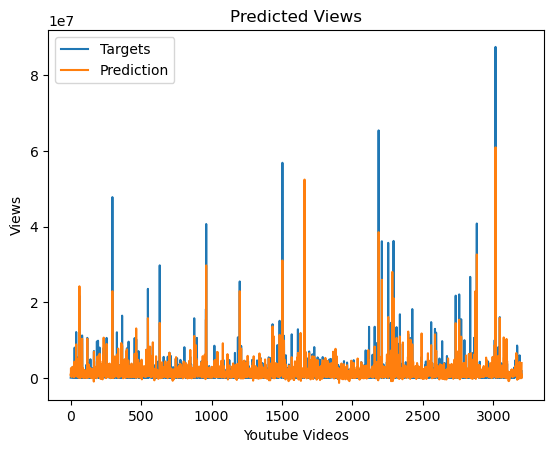

In [ ]:
# Plotting
plt.plot(original_targets, label='Targets')
plt.plot(original_pred, label='Prediction')

# Add labels and title
plt.xlabel('Youtube Videos')
plt.ylabel('Views')
plt.title('Predicted Views')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Join columns with <EOF> tag
df['combined'] = df.apply(lambda row: ' <EOF> '.join([row["channel_title"], row["tags"], row["description"]]), axis=1)

df = df[['combined','views']]
# Print the resulting DataFrame
print(df)

                                                combined     views
0      EminemVEVO <EOF> Eminem|"Walk"|"On"|"Water"|"A...  17158579
1      iDubbbzTV <EOF> plush|"bad unboxing"|"unboxing...   1014651
3      nigahiga <EOF> ryan|"higa"|"higatv"|"nigahiga"...   2095828
4      Ed Sheeran <EOF> edsheeran|"ed sheeran"|"acous...  33523622
5      DramaAlert <EOF> #DramaAlert|"Drama"|"Alert"|"...   1309699
...                                                  ...       ...
41207  Россия 24 <EOF> поединок|"михеев"|"полный конт...    201847
41208  Annoying Orange <EOF> annoying orange|"funny"|...     80685
41210  Kingdom Hearts <EOF> Kingdom Hearts|"KH3"|"Kin...    773347
41211  The Young Turks <EOF> 180612__TB02SorryExcuse|...    115225
41212  我愛小明星大跟班 <EOF> 吳宗憲|"吳姍儒"|"小明星大跟班"|"Sandy"|"Jac...    107392

[32016 rows x 2 columns]
